In [ ]:
!pip install transformers datasets

In [22]:
from datasets import load_dataset
import pandas as pd
data = pd.read_csv('/content/impression_300_llm.csv')

In [23]:
data.head()

,Report Name,History,Observation,Impression
0,MRI Brain Plain,LOC,Possible minimal volume loss of right hippocam...,Possible minimal volume loss of right hippocam...
1,MRI Orbits Plain and Contrast,document attached,The globe is normal shape. The uveoscleral thi...,Minimally increased perineural CSF signal alon...
2,MRI Brain Plain and Contrast,document attached,"No evidence of acute infarct, hemorrhage or sp...",No significant neuroparenchymal abnormality d...
3,MRI Brain Plain and Contrast,HEADACHE,Limited study due to phase encoded pulsation a...,Small vessel ischaemic disease (Fazekas grade ...
4,CT Abdomen & Pelvis Plain and Contrast - Female,PAIN IN RT SIDED UPPER ABDOMEN,The liver is normal sized. Focal fatty infiltr...,Prominently distended gallbladder. No calcifie...


In [24]:
data['input_text'] = data['Report Name'] + ' ' + data['History'] + ' ' + data['Observation']

In [34]:
from transformers import AutoTokenizer
from datasets import Dataset
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [52]:
hf_data = Dataset.from_pandas(data[['input_text', 'Impression']])
def tokenize_function(examples):
    # Determine the actual length of the input text to avoid unnecessary padding
    max_length = min(512, max(len(examples['input_text']), len(examples['Impression'])))

    # Tokenize the input and target with a dynamically set max length
    inputs = tokenizer(examples['input_text'], truncation=True, padding='max_length', max_length=max_length)
    labels = tokenizer(examples['Impression'], truncation=True, padding='max_length', max_length=max_length)

    inputs['labels'] = labels['input_ids']

    return inputs
tokenized_dataset = hf_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

In [49]:
tokenized_dataset = tokenized_dataset.shuffle(seed=42)
train_dataset = tokenized_dataset.select(range(300))
eval_dataset = tokenized_dataset.select(range(300, 330))

# **Fine - Tunning**

In [50]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [51]:
training_args = TrainingArguments(
    output_dir="./fine-tuned-gpt2",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [54]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.166900,2.828616


TrainOutput(global_step=75, training_loss=2.776102066040039, metrics={'train_runtime': 42.4933, 'train_samples_per_second': 7.06, 'train_steps_per_second': 1.765, 'total_flos': 39194512588800.0, 'train_loss': 2.776102066040039, 'epoch': 1.0})

In [56]:
predictions = trainer.predict(eval_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(30, 512, 50257) (30, 512)


In [57]:
import math
eval_loss = trainer.evaluate()['eval_loss']
perplexity = math.exp(eval_loss)
print(f"Perplexity: {perplexity}")

Perplexity: 16.92202290143907


In [ ]:
!pip install rouge-score

In [64]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

scores = []
for i in range(len(reference_text)):
    single_reference_text = reference_text[i]

    predicted_ids = predictions.predictions[i].argmax(axis=-1)

    single_generated_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)

    score = scorer.score(single_reference_text, single_generated_text)
    scores.append(score)

for i, score in enumerate(scores):
    print(f"Scores for reference text {i + 1}: {score}")

Scores for reference text 1: {'rouge1': Score(precision=0.75, recall=0.03225806451612903, fmeasure=0.061855670103092786), 'rougeL': Score(precision=0.75, recall=0.03225806451612903, fmeasure=0.061855670103092786)}
Scores for reference text 2: {'rouge1': Score(precision=0.125, recall=0.019230769230769232, fmeasure=0.03333333333333334), 'rougeL': Score(precision=0.125, recall=0.019230769230769232, fmeasure=0.03333333333333334)}
Scores for reference text 3: {'rouge1': Score(precision=0.7142857142857143, recall=0.03125, fmeasure=0.059880239520958084), 'rougeL': Score(precision=0.7142857142857143, recall=0.03125, fmeasure=0.059880239520958084)}
Scores for reference text 4: {'rouge1': Score(precision=0.09090909090909091, recall=0.025, fmeasure=0.03921568627450981), 'rougeL': Score(precision=0.09090909090909091, recall=0.025, fmeasure=0.03921568627450981)}
Scores for reference text 5: {'rouge1': Score(precision=1.0, recall=0.009708737864077669, fmeasure=0.01923076923076923), 'rougeL': Score(p

## ***Text Analysis***

In [67]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK resources
nltk.download('punkt') # Download punkt sentence tokenizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['processed_text'] = data['input_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
print(data['processed_text'].isnull().sum())
print(data['processed_text'].apply(lambda x: len(x.strip()) == 0).sum())

0
0


In [70]:
data = data.dropna(subset=['processed_text'])
data = data[data['processed_text'].apply(lambda x: len(x.strip()) > 0)]

In [71]:
def get_embeddings(text):
    # Tokenize the text and handle long text appropriately
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Ensure that the input text is not empty after tokenization
    if inputs['input_ids'].size(1) == 0:
        raise ValueError(f"Tokenized text is empty for input: {text}")

    # Move the model and inputs to the correct device (GPU or CPU)
    inputs = {key: value.to(embedding_model.device) for key, value in inputs.items()}

    # Extract the embeddings
    outputs = embedding_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()

In [75]:
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the BERT model and tokenizer (ensure they match)
embedding_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Use BERT tokenizer

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)  # Add truncation and padding
    outputs = embedding_model(**inputs)
    # Get the mean of the last hidden state across all tokens and then convert to a 1D NumPy array
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings.flatten()  # Flatten to 1D

data['embeddings'] = data['processed_text'].apply(get_embeddings)
# Reshape embeddings to a 2D array before calculating cosine similarity
embeddings_2d = np.vstack(data['embeddings'].values) # Stack the embeddings into a 2D array
similarities = cosine_similarity(embeddings_2d)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [80]:
from sklearn.metrics.pairwise import cosine_similarity
import itertools

def find_top_pairs(embeddings, top_n=100):
    pairs = list(itertools.combinations(range(len(embeddings)), 2))
    similarities = [(i, j, cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]) for i, j in pairs]
    sorted_pairs = sorted(similarities, key=lambda x: x[2], reverse=True)
    return sorted_pairs[:top_n]

top_100_pairs = find_top_pairs(data['embeddings'].tolist())

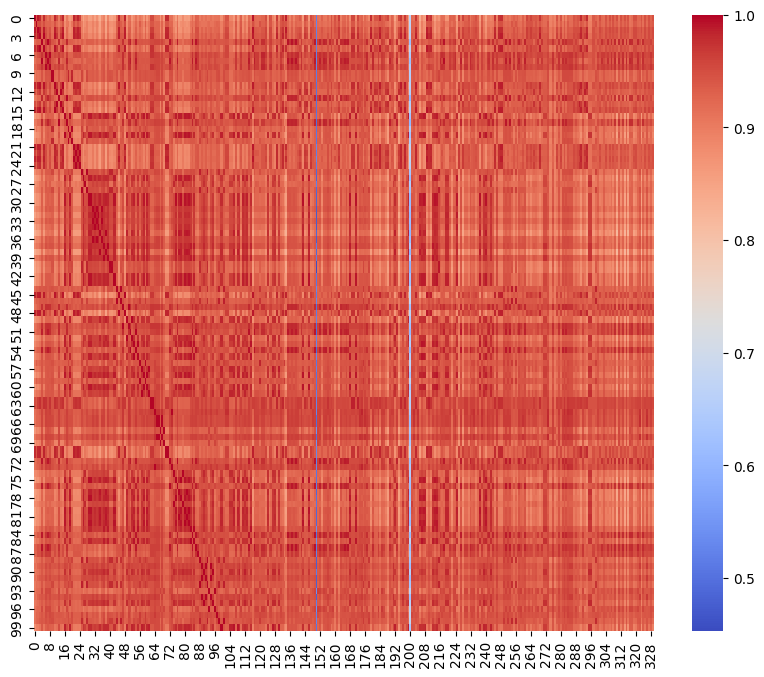

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(similarities[:100], cmap='coolwarm')
plt.show()

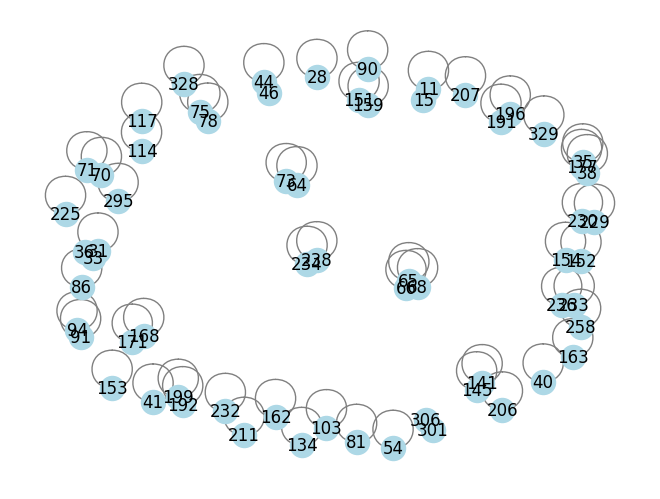

In [77]:
import networkx as nx

# Get the indices of the top 100 pairs
top_indices = np.unravel_index(np.argpartition(similarities, -100, axis=None)[-100:], similarities.shape)

# Create a graph
G = nx.Graph()

# Add nodes and edges
for i, j in zip(top_indices[0], top_indices[1]):
    G.add_edge(i, j, weight=similarities[i, j])

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', width=[d['weight'] for _, _, d in G.edges(data=True)])
plt.show()

In [85]:
trainer.save_model("./fine-tuned-gemma-model")
tokenizer.save_pretrained("./fine-tuned-gemma-model")

('./fine-tuned-gemma-model/tokenizer_config.json',
 './fine-tuned-gemma-model/special_tokens_map.json',
 './fine-tuned-gemma-model/vocab.txt',
 './fine-tuned-gemma-model/added_tokens.json',
 './fine-tuned-gemma-model/tokenizer.json')